Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

In [1]:
STUDENT_ID = "200774408"

---

# Coursework 9

This is the notebook for coursework 9 of module MTH793P at Queen Mary University of London in the academic year 2020 / 2021.

Author: [Martin Benning](mailto:m.benning@qmul.ac.uk)

Date: 30.03.2020

Last updated: 30.03.2021

First we load the necessary libraries.

In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2

## Dual numbers and automatic differentiation

In this coursework we want to implement the forward mode of automatic differentiation with the help of dual numbers. We first implement a class **Dual** with the constructor **__init__**, the functions **__add__**, **__radd__**, **__sub__**, **__rsub__**, **__mul__**, **__rmul__**, **__matmul__**, **__rmatmul__**, **__truediv__**, **__rtruediv__**, **__neg__** and **__pow__**, and the property **T**. As the names suggest, those  functions and properties implement basic arithmetic operations for Dual numbers:

__init__ : constructor that initialises an object of class **Dual**. Each object represents a dual number $a + \varepsilon \, b$ with real component $a$ (*self.real*) and dual component $b$ (*self.dual*).

__add__ : adds an argument _argument_ to the dual number, i.e. $a + \varepsilon \, b + \text{argument}$. 

__radd__ : adds the dual number to the argument _argument_, i.e. $\text{argument} + a + \varepsilon \, b$.

__sub__ : subtracts an argument _argument_ from the dual number. 

__rsub__ : subtracts the dual number from the argument _argument_.

__mul__ : multiplies the dual number with the argument _argument_.

__rmul__ : multiplies an argument _argument_ with the dual number. 

__matmul__ : multiplies the dual number to the matrix-argument _argument_. 

__rmatmul__ : multiplies the the matrix-argument _argument_ to the dual number.

__truediv__ : divides the dual number by an argument _argument_.

__rtruediv__ : divides the argument _argument_ by the dual number.

__neg__ : returns the neagtive of the dual number $a + \varepsilon b$, i.e. $-a - \varepsilon b$.

__pow__ : takes the _power_-th power of the dual number.

**T** : returns the transpose of the dual number.

In [3]:
class Dual:
    def __init__(self, real, dual):
        self.real = real
        self.dual = dual
    
    @staticmethod
    def expand(arg):
        if isinstance(arg, Dual):
            real, dual = arg.real, arg.dual
        else:
            real, dual = arg, 0
        return real, dual
        
    def __add__(self, argument):
        if isinstance(argument, Dual):
            return Dual(self.real + argument.real, self.dual + argument.dual)
        else:
            return Dual(self.real + argument, self.dual)
        
    __radd__ = __add__
    
    def __sub__(self, argument):
        # self - argument
        r2, d2 = self.expand(argument)
        return Dual(self.real - r2, self.dual - d2)
        
    def __rsub__(self, argument):
        # argument - self
        r2, d2 = self.expand(argument)
        return Dual(-self.real + r2, -self.dual + d2)
        
    def __mul__(self, argument):
        r2, d2 = self.expand(argument)
        return Dual(self.real * r2, self.dual * r2 + d2 * self.real)
        
    __rmul__ = __mul__
    
    def __matmul__(self, argument):
        real = self.real @ argument.real
        dual = self.real @ argument.dual + self.dual @ argument.real
        return Dual(real, dual)
        
    def __rmatmul__(self, argument):
        return argument.__matmul__(self)
    
    def __truediv__(self, argument):
        r2, d2 = self.expand(argument)
        a, b, c, d = self.real, self.dual, r2, d2
        real = a / c
        dual = (b * c - a * d) / c ** 2
        return Dual(real, dual)
        
    def __rtruediv__(self, argument):
        r2, d2 = self.expand(argument)
        return Dual(r2, d2).__truediv__(self)
        
    def __neg__(self):
        return Dual(-self.real, -self.dual)
    
    def __pow__(self, power):
        val = 1
        for i in range(power):
            val *= self
        return val
    
    def __repr__(self):                    
        if self.dual == 0:
            representation = repr(self.real)    
        elif self.dual == 1:
            representation = repr(self.real) + ' + epsilon'
        elif self.dual == -1:
            representation = repr(self.real) + ' - epsilon'
        elif self.dual > 0:
            representation = repr(self.real) + ' + ' + repr(self.dual) + ' * epsilon'
        else:
            representation = repr(self.real) + ' - ' + repr(-self.dual) + ' * epsilon'
        return representation
    
    def __str__(self):
        if self.dual == 0:
            representation = str(self.real)    
        elif self.dual == 1:
            representation = str(self.real) + " + epsilon"
        elif self.dual == -1:
            representation = str(self.real) + " - epsilon"
        elif self.dual > 0:
            representation = str(self.real) + " + " + str(self.dual) + " * epsilon"
        else:
            representation = str(self.real) + " - " + str(-self.dual) + " * epsilon"
        return representation
    
    @property
    def T(self):
        real = self.real.T
        dual = self.dual.T
        return Dual(real, dual)

Test your class with the following tests, one visible, one hidden. One mark each, **2/10** marks in total.

In [4]:
from numpy.testing import assert_array_equal
a = Dual(9, -1)
b = Dual(-3, 7)
c = a / b
assert_array_equal(c.real, -3)
assert_array_equal(c.dual, -20/3)

In [5]:
from numpy.testing import assert_array_almost_equal

Next, we implement the following functions that are acting on dual numbers of the form $a + \varepsilon \, b$:
    
**log** : $\log(a + \varepsilon \, b)$

**exp** : $\exp(a + \varepsilon \, b)$

**sin** : $\sin(a + \varepsilon \, b)$

**cos** : $\cos(a + \varepsilon \, b)$

**sigmoid** : $\frac{1}{1 + \exp(-(a + \varepsilon \, b))}$

**dual_sum** : $\sum_{j = 1}^n a_j + \varepsilon \, b_j$; sum can be taken across individual array-dimensions.

In [6]:
def log(dual_number):
    return Dual(np.log(dual_number.real), dual_number.dual / dual_number.real)

def exp(dual_number):
    real = np.exp(dual_number.real)
    dual = dual_number.dual * np.exp(dual_number.real)
    return Dual(real, dual)
    
def sin(dual_number):
    real = np.sin(dual_number.real)
    dual = dual_number.dual * np.cos(dual_number.real)
    return Dual(real, dual)
    
def cos(dual_number):
    real = np.cos(dual_number.real)
    dual = -dual_number.dual * np.sin(dual_number.real)
    return Dual(real, dual)

def σ(x): return 1 / (1 + np.exp(-x))
def sigmoid(dual_number):
    real = σ(dual_number.real)
    dual = dual_number.dual * σ(dual_number.real) * (1 - σ(dual_number.real))
    return Dual(real, dual)

def dual_sum(dual_number, axis=None):
    real = dual_number.real.sum()
    dual = dual_number.dual.sum()
    return Dual(real, dual)

We test the functions with the following three cells (two visible, one hidden) that are worth **3/10** marks.

In [7]:
x = Dual(np.random.randn(1, 1), 1)
f = sin(3*(x ** 2) - 2*x)/exp(1 + cos(-5*(x ** 2)))

def symbolic_derivative_of_f(x):
    output = np.exp(-np.cos(5*(x ** 2)) - 1) * ((6*x - 2)*np.cos((2 - 3*x)*x) - \
                    10*x*np.sin((2 - 3*x)*x)*np.sin(5*(x ** 2)))
    return output

assert_array_almost_equal(f.dual, symbolic_derivative_of_f(x.real))

In [8]:
data_matrix = Dual(np.random.randn(100, 5), np.zeros((100, 5)))
data = Dual(np.random.randn(100, 1), np.zeros((100, 1)))
index = np.random.randint(0, 5)
delta = np.zeros((5, 1))
delta[index] = 1
weights = Dual(np.random.randn(5, 1), delta)

mean_squared_error = 1/2 * dual_sum((data_matrix @ weights - data) ** 2)
manual_gradient = data_matrix.real.T @ (data_matrix.real @ weights.real - data.real)

assert_array_almost_equal(mean_squared_error.dual, manual_gradient[index])

## Autoencoders

In this part we focus on the implementation of autoencoders with PyTorch. We load several PyTorch libraries first.

In [9]:
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as fct
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

Next, we load the training and test samples of the Fashion MNIST dataset with the help of torchvision.

In [10]:
torch.set_default_tensor_type(torch.FloatTensor)
training_batch_size = 150
test_batch_size = 150

full_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [1])
            ])), 
        batch_size=60000, shuffle=True, num_workers=4)

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [1])
            ])), 
        batch_size=training_batch_size, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [1])
            ])), 
        batch_size=test_batch_size, shuffle=True)

## Linear autoencoder

Next, we implement a linear autoencoder. In order to do so, we write a class **LinearAutoencoder** with a constructor, three functions **encoder**, **decoder** and **evaluate**, and a variable *decoder_matrix*. Based on a two-dimensional tensor *data* and the integer *rank*, the constructor computes the decoder matrix $U_{\text{rank}}$, where $U_{\text{rank}}$ are the first *rank* columns of the matrix $U$ that satisfies $X = U\Sigma V^\top$, where $X$ is the mathematical representation of *data*. Based on the decoder matrix, the function **encoder** encodes an input tensor *inputs*, the function **decoder** decodes an input tensor *inputs*, and the function **evaluate** computes the decoding of the encoding of an input tensor *inputs*.

In [11]:
class LinearAutoencoder():
    def __init__(self, data, rank):
        self.rank = rank
        self.data = data
        self.decoder_matrix = torch.svd(data).U[:, :rank]
        
    def encoder(self, inputs):
        return self.decoder_matrix.T @ inputs
    
    def decoder(self, inputs):
        return self.decoder_matrix @ inputs
    
    def evaluate(self, inputs):
        encode = self.encoder(inputs)
        signal = self.decoder(encode)
        return signal

We test the functions with the following two cells (one visible, one hidden) that are worth **2/10** marks.

In [12]:
tensor = torch.Tensor([[3, 2, 2], [2, 3, -2]])
linear_autoencoder = LinearAutoencoder(tensor, 1)
approximation = linear_autoencoder.evaluate(tensor)
assert_array_almost_equal(approximation.numpy(), np.array([[2.5, 2.5, 0], [2.5, 2.5, 0]]))

We create a linear autoencoder based on the Fashion MNIST dataset, which will act as a baseline comparison when we compare neural network based autoencoders later.

In [13]:
full_batch = next(iter(full_loader))[0]
linear_autoencoder = LinearAutoencoder(full_batch.view(60000, 784).T, 392)

We visualise the linear autoencoding with a comparison of a random sample of the Fashion MNIST dataset and its approximation of rank 392.

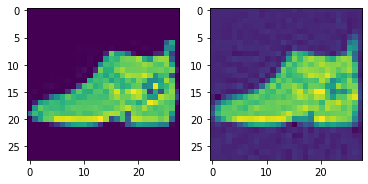

In [14]:
codes = linear_autoencoder.encoder(full_batch.view(60000, 784).T)
approximations = linear_autoencoder.decoder(codes).T.view(60000, 1, 28, 28)
plt.subplot(1, 2, 1)
plt.imshow(full_batch[4][0].detach())
plt.subplot(1, 2, 2)
plt.imshow(approximations[4][0].detach());

## Neural network autoencoders

In this section, we experiment with neural network based autoencoders for the coding an decoding of the Fashion MNIST dataset, and try to develop non-linear architectures that can beat linear autoencoders. For this, we design an autoencoder with the following **Autoencoder** class. The class has a constructor that initialises all relevant neural network components that are necessary for the execution of the functions **encoder** and **decoder**. As the names suggest, the **encoder** function transform inputs _inputs_ into codes, while the **decoder** function transforms *codes* into signals again. The function **forward** is a composition of the functions **encoder** and **decoder**. You are completely free in designing your neural network; tests won't depend on specific architectural choices. Please note that the autoencoder only has to work for signals that match the dimensions of the Fashion MNIST dataset.

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encode_1 = nn.Linear(784, 100)
        self.encode_2 = nn.Linear(100, 32)
        self.decode_1 = nn.Linear(32, 100)
        self.decode_2 = nn.Linear(100, 784)
        self.relu = nn.ReLU()
    
    def encoder(self, inputs):
        inputs = torch.flatten(inputs, start_dim=1)
        h1 = self.relu(self.encode_1(inputs))
        h2 = self.encode_2(h1)
        return h2
    
    def decoder(self, codes):
        h3 = self.relu(self.decode_1(codes))
        h4 = self.decode_2(h3)
        output = h4.reshape(-1, 1, 28, 28)
        return output
    
    def forward(self, inputs):        
        return self.decoder(self.encoder(inputs))

Test your network with the following two cells (one visible, one hidden). The tests only check if the autoencoder produces outputs of the correct dimensions, but doesn't check for specific values. The tests are worth **2/10** marks.

In [16]:
autoencoder = Autoencoder()
training_batch = next(iter(train_loader))[0]
untrained_output = autoencoder(training_batch)

assert_array_equal(untrained_output.shape, np.array([150, 1, 28, 28]))

Next, we write a routine to train the network parameters. You can write your own routine from scratch, or base it on the template below. Your routine should be able to incorporate different networks, data loader objects, optimisers and optimisation criteria.

In [17]:
# Run autoencoder.py to save 'autoencoder' model

Use a seperate notebook or Python file to train your network on the data specified by the data loader *train_loader*. Once you have trained your network to satisfaction, save the parameters of your autoencoder via *torch.save(autoencoder.state_dict(), 'autoencoder')* into a file named *autoencoder*. Submit your file together with your template notebook. The following test will check if you have submitted your parameters and if they are compatible with your network architecture. The test is worth **1/10** marks.

In [18]:
autoencoder.load_state_dict(torch.load('autoencoder'))

<All keys matched successfully>

With the following cell we compute the network output when applying the network to a sample of the training data.

In [19]:
autoencoder.eval()
train_batch = next(iter(train_loader))
reconstruction = autoencoder(train_batch[0])
code = autoencoder.encoder(train_batch[0])
linear_reconstruction = linear_autoencoder.evaluate(train_batch[0].view(training_batch_size, 784).T).T.view( \
                                                    training_batch_size, 1, 28, 28)

With the following cell we visualise the network output when applying it to a sample of training data.

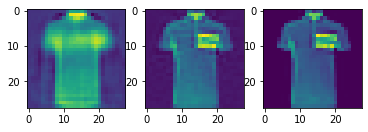

In [20]:
plt.subplot(1, 3, 1)
plt.imshow(reconstruction[1][0].detach())
plt.subplot(1, 3, 2)
plt.imshow(linear_reconstruction[1][0].detach())
plt.subplot(1, 3, 3)
plt.imshow(train_batch[0][1][0].detach());

We repeat the same exercise for a training data sample.

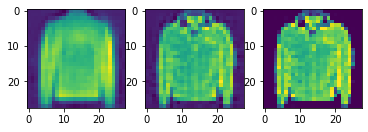

In [21]:
test_batch = next(iter(test_loader))
reconstruction = autoencoder(test_batch[0])
code = autoencoder.encoder(test_batch[0])
linear_reconstruction = linear_autoencoder.evaluate(test_batch[0].view(test_batch_size, 784).T).T.view( \
                                                    test_batch_size, 1, 28, 28)

plt.subplot(1, 3, 1)
plt.imshow(reconstruction[1][0].detach())
plt.subplot(1, 3, 2)
plt.imshow(linear_reconstruction[1][0].detach())
plt.subplot(1, 3, 3)
plt.imshow(test_batch[0][1][0].detach());

We conclude this notebook by visualising the code that the encoder produces for a random input sample.

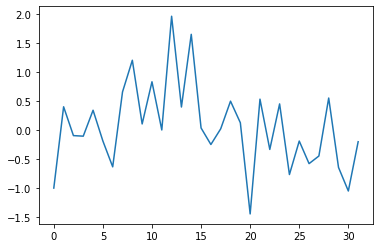

In [22]:
plt.plot(code[1].detach());

This is the end of this week's coursework.

In [23]:
!open .